In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from termcolor import colored
from statsmodels.tsa.deterministic import DeterministicProcess
import datetime

In [15]:
fpth = 'data/us-retail-sales.csv'
time_column = 'Month'
cols_to_drop = None

retail_sales = pd.read_csv(fpth, index_col= time_column, parse_dates = True)
if cols_to_drop:
    retail_sales = retail_sales.drop(cols_to_drop, axis=1)
retail_sales = retail_sales.to_period('M') # required to make `out_of_sample` to work properly # change df.index to df.index.to_timestamp() while plotting
retail_sales.head(3)

,Clothing,Appliances,FoodAndBeverage,Automobiles,GeneralMerchandise,BuildingMaterials
Month,,,,,,
1992-01,6938,3657,29589,26788,14996,8964
1992-02,7524,3490,28570,28203,16015,9023
1992-03,8475,3669,29682,31684,17984,10608


In [16]:
fpth = 'store-sales-time-series-forecasting/train.csv'
time_column = 'date'
cols_to_drop = ['id']

store_sales = pd.read_csv(fpth, index_col= time_column, parse_dates = True)
store_sales = store_sales.to_period('D')
if cols_to_drop:
    store_sales = store_sales.drop(cols_to_drop, axis=1)
store_sales.head(3)

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0


In [17]:
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
store_sales.head(3)

sales  onpromotion
date       store_nbr family                        
2013-01-01 1         AUTOMOTIVE    0.0            0
                     BABY CARE     0.0            0
                     BEAUTY        0.0            0

In [18]:
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']
average_sales = store_sales.groupby('date').mean()['sales']

In [22]:
len(food_sales), food_sales.head()

(336,
 Month
 1992-01    29589
 1992-02    28570
 1992-03    29682
 1992-04    30228
 1992-05    31677
 Freq: M, Name: FoodAndBeverage, dtype: int64)

In [23]:
len(auto_sales), auto_sales.head()

(336,
 Month
 1992-01    26788
 1992-02    28203
 1992-03    31684
 1992-04    32547
 1992-05    32883
 Freq: M, Name: Automobiles, dtype: int64)

In [24]:
len(average_sales), average_sales.head()

(1684,
 date
 2013-01-01      1.409438
 2013-01-02    278.390807
 2013-01-03    202.840197
 2013-01-04    198.911154
 2013-01-05    267.873244
 Freq: D, Name: sales, dtype: float64)

#### Moving average plots

In [11]:
df_dict = {'F&B': food_sales, 'Auto': auto_sales, 'store_sales': average_sales}

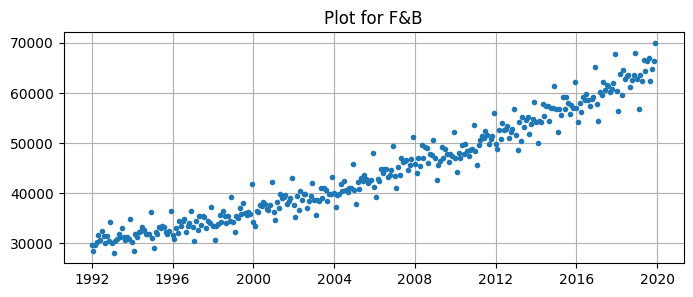

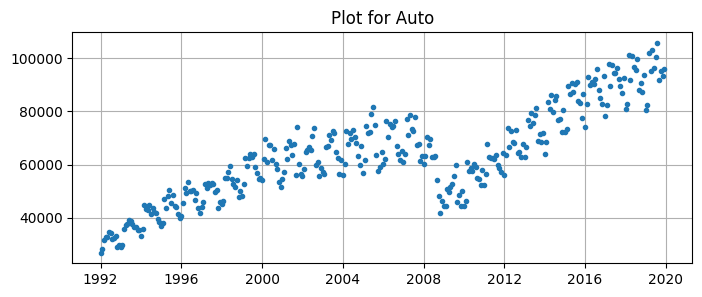

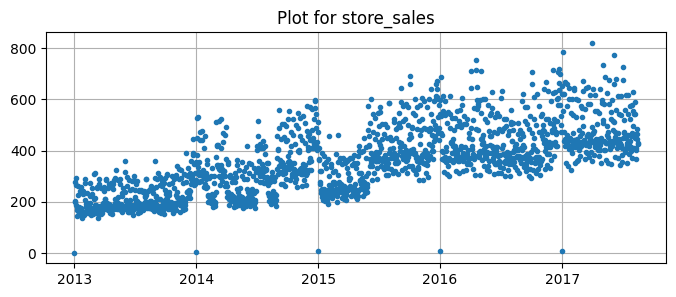

In [33]:
for name, df in df_dict.items():
    df = df.to_frame()
    fig, ax = plt.subplots(figsize=(8,3))
    if isinstance(df.index[0], pd.Timestamp):
        ax.plot(df.index, df.values, '.') # scatter
    if isinstance(df.index[0], pd.Period):
        ax.plot(df.index.to_timestamp(), df.values, '.') # scatter  
    ax.set_title(f'Plot for {name}')
    ax.grid()
    plt.show()

Seems like there are small wave-like seasonal behaviour evry year. So, we make `window_size` of 365 days or 12 Months

In [41]:
df_dict = {
    'F&B': [food_sales,'FoodAndBeverage', 12, 5], 
    'Auto': [auto_sales,'Automobiles', 12, 5], 
    'store_sales': [average_sales, 'sales', 365, 90]
}

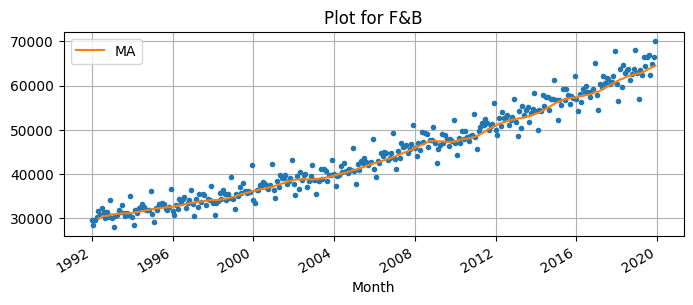

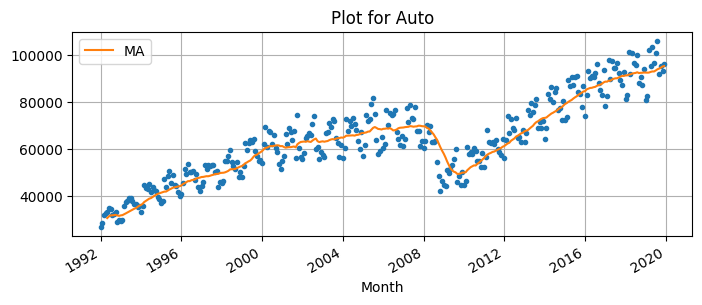

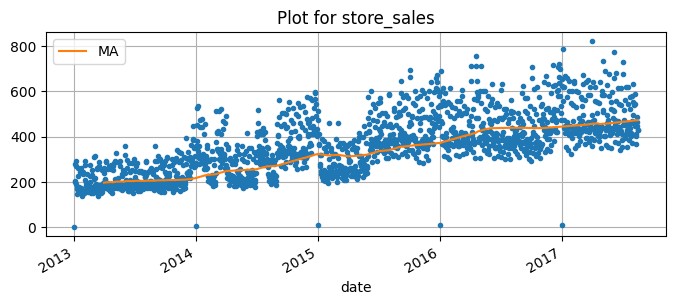

In [42]:
for name, data in df_dict.items():
    df, indep, window_sz, min_sz = data
    df = df.to_frame()
    moving_avg = df[indep].rolling(window=window_sz, min_periods=min_sz, center=False).mean()
    
    fig, ax = plt.subplots(figsize=(8,3))
    if isinstance(df.index[0], pd.Timestamp):
        ax.plot(df.index, df.values, '.') # scatter
    if isinstance(df.index[0], pd.Period):
        ax.plot(df.index.to_timestamp(), df.values, '.') # scatter  
    ax.set_title(f'Plot for {name}')
    moving_avg.plot(ax=ax, label='MA')
    ax.grid()
    ax.legend()
    plt.show()

### Identifying Trend
- Experiment with multiple options for Trend `order` and pick one that resembles most with Moving Average `moving_avg`  OR which results in highest `r2_score` or least `MSE` or combination of latter two.

In [46]:
# Check for missing dates, NOT DOING HERE, but already included in Previous chapters

In [86]:
df_dict = {
    'F&B': [food_sales,'FoodAndBeverage', 12, 5, 1], 
    'Auto': [auto_sales,'Automobiles', 12, 5, 1], 
    'store_sales': [average_sales, 'sales', 365, 90, 1]
}

For F&B
X.shape, y.shape:  (336, 2) (336,)
Linear Regression score: 0.9450450218964186 
MSE: 5976715.834676804 
FoodAndBeverage = 0.0 + 27056.40778251601 x const + 104.5219016722237 x trend

2


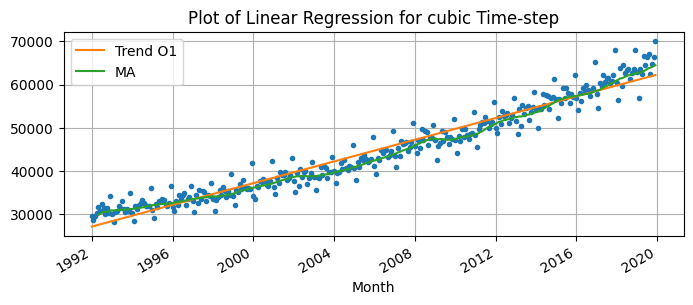

For Auto
X.shape, y.shape:  (336, 2) (336,)
Linear Regression score: 0.7114451736561431 
MSE: 87695481.17757265 
Automobiles = 0.0 + 38031.85939943143 x const + 151.59972873023588 x trend

2


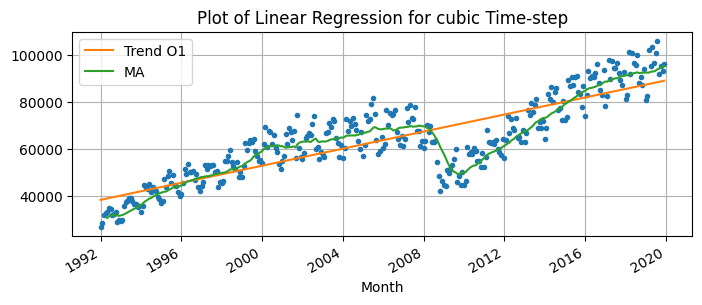

For store_sales
X.shape, y.shape:  (1684, 2) (1684,)
Linear Regression score: 0.5161529745128401 
MSE: 8367.348884540073 
sales = 0.0 + 194.03844322387954 x const + 0.1943469506097797 x trend

2


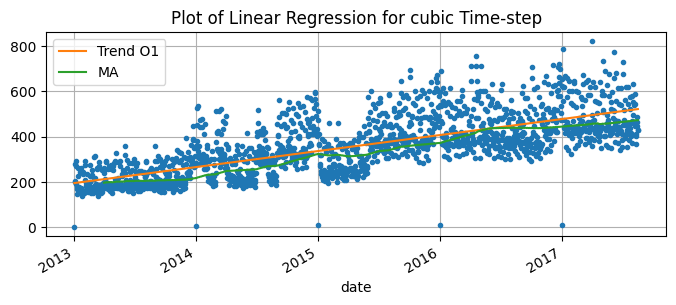

In [87]:
for name, data in df_dict.items():
    print(f'For {name}')
    df, indep, window_sz, min_sz, order = data
    df = df.to_frame()
    moving_avg = df[indep].rolling(window=window_sz, min_periods=min_sz, center=False).mean()

    dp = DeterministicProcess(
        index = df.index, # dates from training data
        constant= True, # dummy feature for bias
        order = order, # order of Trendline 1-linear, 2-quadratic
        drop = True # check for perfect collinearity and drop any linearly dependent terms
    )
    
    X = dp.in_sample()
    y = df[indep]
    
    print('X.shape, y.shape: ', X.shape, y.shape)
    #print('X:\n', X.head(2), '\n\ny: \n', y.head(2))
    
    # Model
    lr = LinearRegression(fit_intercept=False) # because x0=1 term is present in X
    lr.fit(X,y)
    print(colored(f'Linear Regression score: {lr.score(X, y)} ', 'red', attrs=['bold']))
    
    # Predictions
    y_pred = lr.predict(X)
    
    # make preds as a dataframe
    y_pred = pd.Series(y_pred, index = X.index)
    #print('\n\nPredictions:\n', y_pred.head(2))
    print(colored(f'MSE: {mean_squared_error(y, y_pred)} ', 'red', attrs=['bold']))
    
    # Equation
    formula = f'{indep} = {lr.intercept_}'
    for i in range(X.shape[1]):
        formula += f' + {lr.coef_[i]} x {list(X.columns)[i]}'
    
    print(colored(formula, 'red', attrs=['bold']))
    print()
    fig, ax = plt.subplots(figsize=(8,3))
    if isinstance(df.index[0], pd.Timestamp):
        print('1')
        ax.plot(df.index, df.NumVehicles, '.') # scatter
    if isinstance(df.index[0], pd.Period):
        print('2')
        ax.plot(df.index.to_timestamp(), df[indep], '.') # scatter  
    y_pred.plot(ax=ax, label = f'Trend O{order}')
    moving_avg.plot(ax=ax, label='MA')
    ax.set_title(f'Plot of Linear Regression for cubic Time-step')
    ax.grid()
    ax.legend()
    plt.show()

Let's programatically search for best order which results in the highest `r2_score`

In [88]:
df_dict = {
    'F&B': [food_sales,'FoodAndBeverage', 12, 5, 4], 
    'Auto': [auto_sales,'Automobiles', 12, 5, 4], 
    'store_sales': [average_sales, 'sales', 365, 90, 4]
}

For F&B
X.shape, y.shape:  (336, 3) (336,)
Linear Regression score: 0.9643069454604979 
MSE: 3881854.7766889622 
FoodAndBeverage = 0.0 + 30321.837025044122 x const + 46.55570210072431 x trend + 0.1720065269184019 x trend_squared



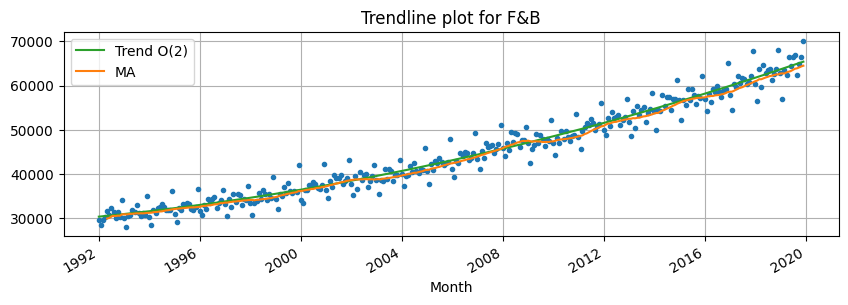

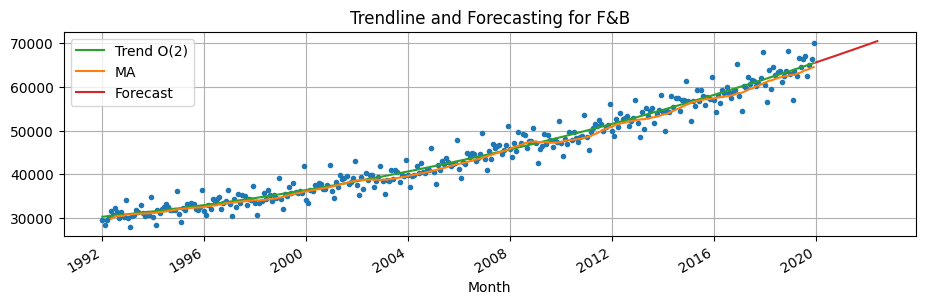

For Auto
X.shape, y.shape:  (336, 4) (336,)
Linear Regression score: 0.8171969679661174 
MSE: 55556166.07787107 
Automobiles = 0.0 + 24430.7391230115 x const + 659.7045361664522 x trend + -3.886291442486685 x trend_squared + 0.007850055123185484 x trend_cubed



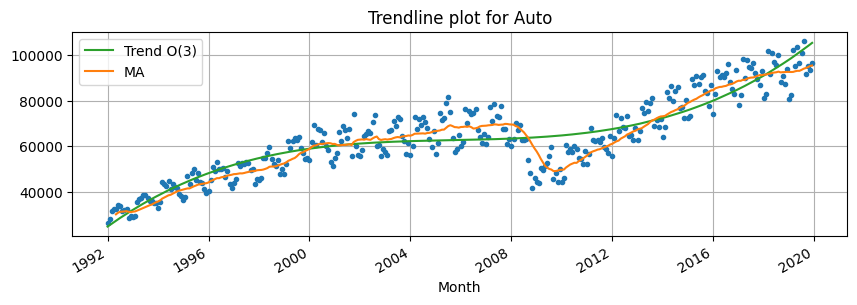

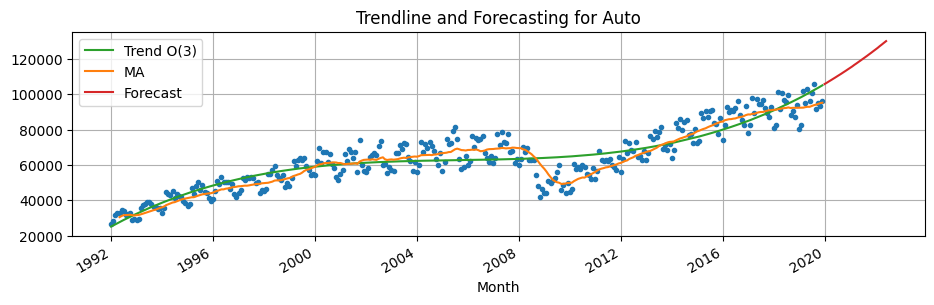

For store_sales
X.shape, y.shape:  (1684, 4) (1684,)
Linear Regression score: 0.524526184100086 
MSE: 8222.547816827979 
sales = 0.0 + 184.8497710508147 x const + 0.1747171753745773 x trend + 0.00010485513623201707 x trend_squared + -6.147304135173393e-08 x trend_cubed



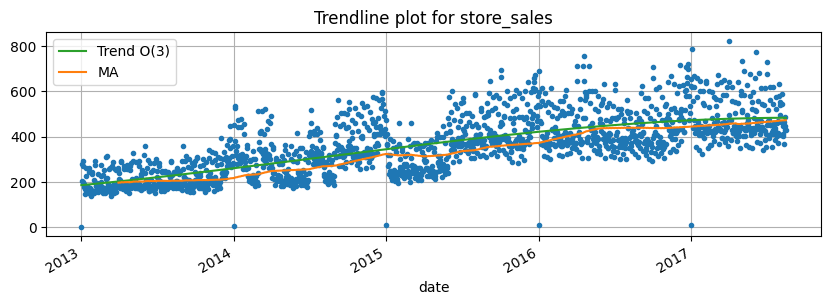

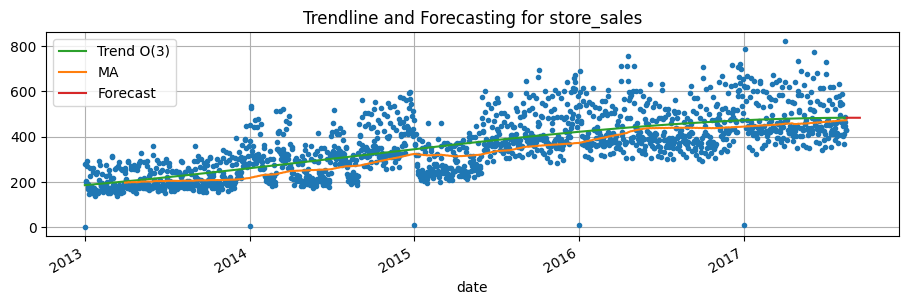

In [105]:
for name, data in df_dict.items():
    print(colored(f'For {name}', 'blue', attrs = ['bold']))
    df, indep, window_sz, min_sz, max_order = data
    df = df.to_frame()
    moving_avg = df[indep].rolling(window=window_sz, min_periods=min_sz, center=False).mean()
    best_order = 1
    best_r2score = 0
    delta = 1e-4

    for o in np.linspace(start=1, stop=max_order, num=max_order):
        dp = DeterministicProcess(
            index = df.index, # dates from training data
            constant= True, # dummy feature for bias
            order = o, # order of Trendline 1-linear, 2-quadratic
            drop = True # check for perfect collinearity and drop any linearly dependent terms
        )
        
        X = dp.in_sample()
        y = df[indep]
        lr = LinearRegression(fit_intercept=False) # because x0=1 term is present in X
        lr.fit(X,y)
        score = lr.score(X, y)
        if score>best_r2score and score-best_r2score>=delta:
            #print(o, best_r2score, score, score-best_r2score)
            best_r2score = score
            best_order = int(o)
        else:
            break

    dp = DeterministicProcess(
        index = df.index, # dates from training data
        constant= True, # dummy feature for bias
        order = best_order, # order of Trendline 1-linear, 2-quadratic
        drop = True # check for perfect collinearity and drop any linearly dependent terms
    )
    
    X = dp.in_sample()
    y = df[indep]
    
    print('X.shape, y.shape: ', X.shape, y.shape)
    #print('X:\n', X.head(2), '\n\ny: \n', y.head(2))
    
    # Model
    lr = LinearRegression(fit_intercept=False) # because x0=1 term is present in X
    lr.fit(X,y)
    print(colored(f'Linear Regression score: {lr.score(X, y)} ', 'red', attrs=['bold']))
    
    # Predictions
    y_pred = lr.predict(X)
    
    # make preds as a dataframe
    y_pred = pd.Series(y_pred, index = X.index)
    #print('\n\nPredictions:\n', y_pred.head(2))
    print(colored(f'MSE: {mean_squared_error(y, y_pred)} ', 'red', attrs=['bold']))
        
    # Equation
    formula = f'{indep} = {lr.intercept_}'
    for i in range(X.shape[1]):
        formula += f' + {lr.coef_[i]} x {list(X.columns)[i]}'
    
    print(colored(formula, 'red', attrs=['bold']))
    print()
    fig, ax = plt.subplots(figsize=(10,3))
    if isinstance(df.index[0], pd.Timestamp):
        ax.plot(df.index, df.NumVehicles, '.') # scatter
    if isinstance(df.index[0], pd.Period):
        ax.plot(df.index.to_timestamp(), df[indep], '.') # scatter  
    y_pred.plot(ax=ax, label = f'Trend O({best_order})', color='C2')
    moving_avg.plot(ax=ax, label='MA')
    ax.set_title(f'Trendline plot for {name}')
    ax.grid()
    ax.legend()
    plt.show()
    
    # Forecast for next 30 timesteps
    X_fore = dp.out_of_sample(steps=30) # 30 new more days
    y_fore = pd.Series(lr.predict(X_fore), index = X_fore.index)
    fig, ax = plt.subplots(figsize=(11,3))
    if isinstance(df.index[0], pd.Timestamp):
        ax.plot(df.index, df.NumVehicles, '.') # scatter
    if isinstance(df.index[0], pd.Period):
        ax.plot(df.index.to_timestamp(), df[indep], '.') # scatter  
    y_pred.plot(ax=ax, label = f'Trend O({best_order})', color='C2')
    moving_avg.plot(ax=ax, label='MA')
    y_fore.plot(ax=ax, label = 'Forecast', color = 'C3',)
    ax.set_title(f'Trendline and Forecasting for {name}')
    ax.grid()
    ax.legend()
    plt.show()
